In [51]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import numpy as np
import pandas as pd

from io import StringIO

from sklearn.cluster import KMeans, AgglomerativeClustering, BisectingKMeans, MiniBatchKMeans

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
cm = sns.light_palette(color="blue", as_cmap=True)
plt.style.use("ggplot")
%matplotlib inline

In [2]:
amazon = pd.read_csv("CC GENERAL.csv").drop("CUST_ID", axis="columns")
print(f"Shape: {amazon.shape}")
amazon.head().style.background_gradient(cmap="viridis")

Shape: (8950, 17)


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.400000,0.000000,95.400000,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.000000,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.000000,0.000000,0.000000,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.000000,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.170000,773.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.000000,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.000000,1499.000000,0.000000,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.000000,0.000000,nan,0.000000,12
4,817.714335,1.000000,16.000000,16.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.000000,678.334763,244.791237,0.000000,12


In [3]:
list(amazon)

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [4]:
info_str = StringIO()
amazon.info(buf=info_str)
print(info_str.getvalue())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [5]:
amazon.describe().T.style.background_gradient(cmap="viridis")

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.000000,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.138560
BALANCE_FREQUENCY,8950.000000,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.000000
PURCHASES,8950.000000,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.570000
ONEOFF_PURCHASES,8950.000000,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.250000
INSTALLMENTS_PURCHASES,8950.000000,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.000000
CASH_ADVANCE,8950.000000,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.211760
PURCHASES_FREQUENCY,8950.000000,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.000000
ONEOFF_PURCHASES_FREQUENCY,8950.000000,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.000000,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.000000
CASH_ADVANCE_FREQUENCY,8950.000000,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.500000


In [6]:
pd.DataFrame(amazon.isnull().sum(), columns=["Null value count"]).style.background_gradient(cmap="viridis")

,Null value count
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0
CASH_ADVANCE_FREQUENCY,0


In [7]:
pd.DataFrame(amazon.nunique(), columns=["nunique"]).style.background_gradient(cmap="viridis")

,nunique
BALANCE,8871
BALANCE_FREQUENCY,43
PURCHASES,6203
ONEOFF_PURCHASES,4014
INSTALLMENTS_PURCHASES,4452
CASH_ADVANCE,4323
PURCHASES_FREQUENCY,47
ONEOFF_PURCHASES_FREQUENCY,47
PURCHASES_INSTALLMENTS_FREQUENCY,47
CASH_ADVANCE_FREQUENCY,54


## Exploratory data analysis

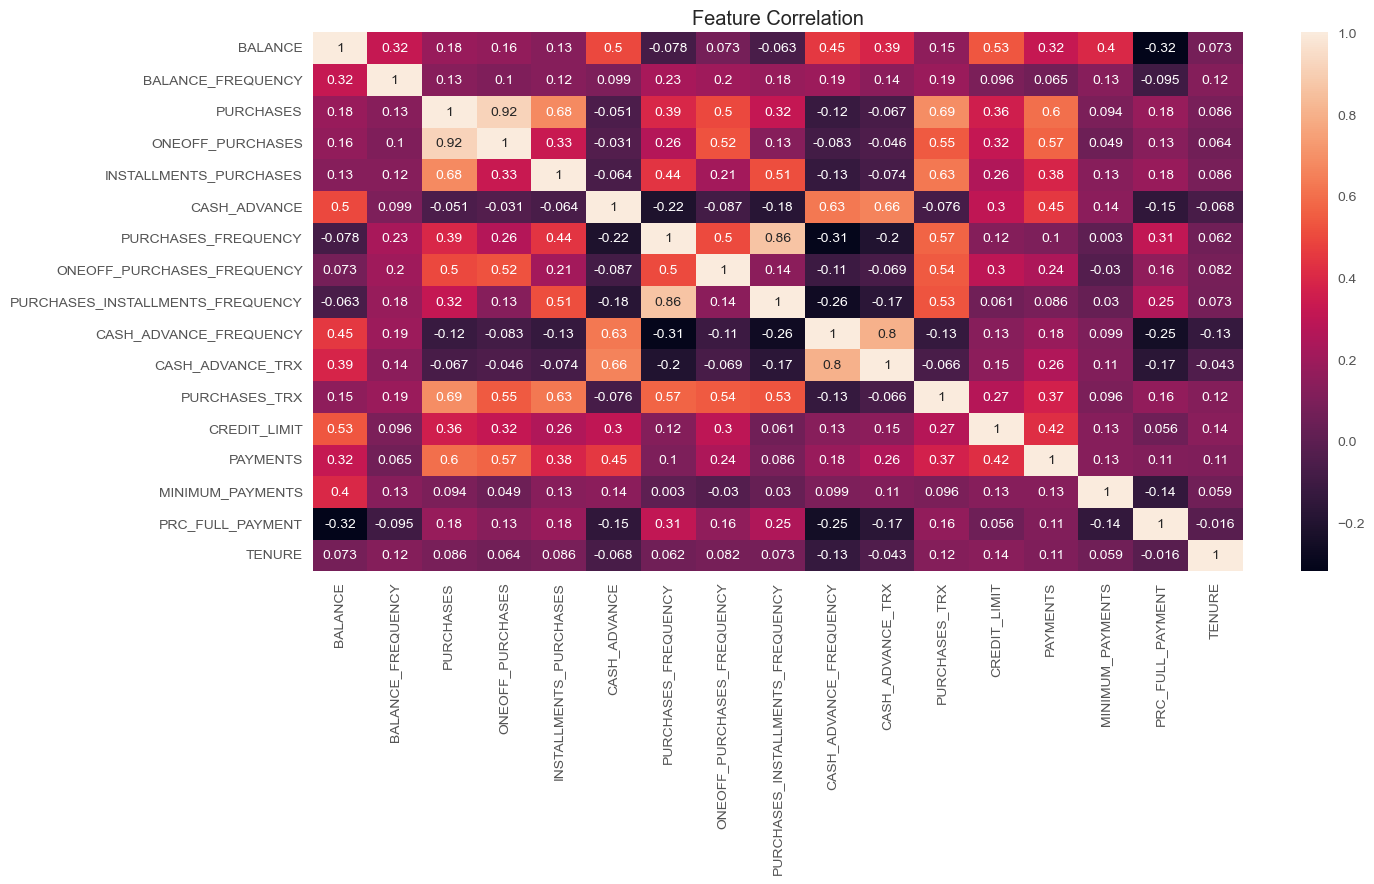

In [8]:
plt.figure(figsize=(15, 7))
sns.heatmap(amazon.corr(), annot=True)
plt.title("Feature Correlation")
plt.show()

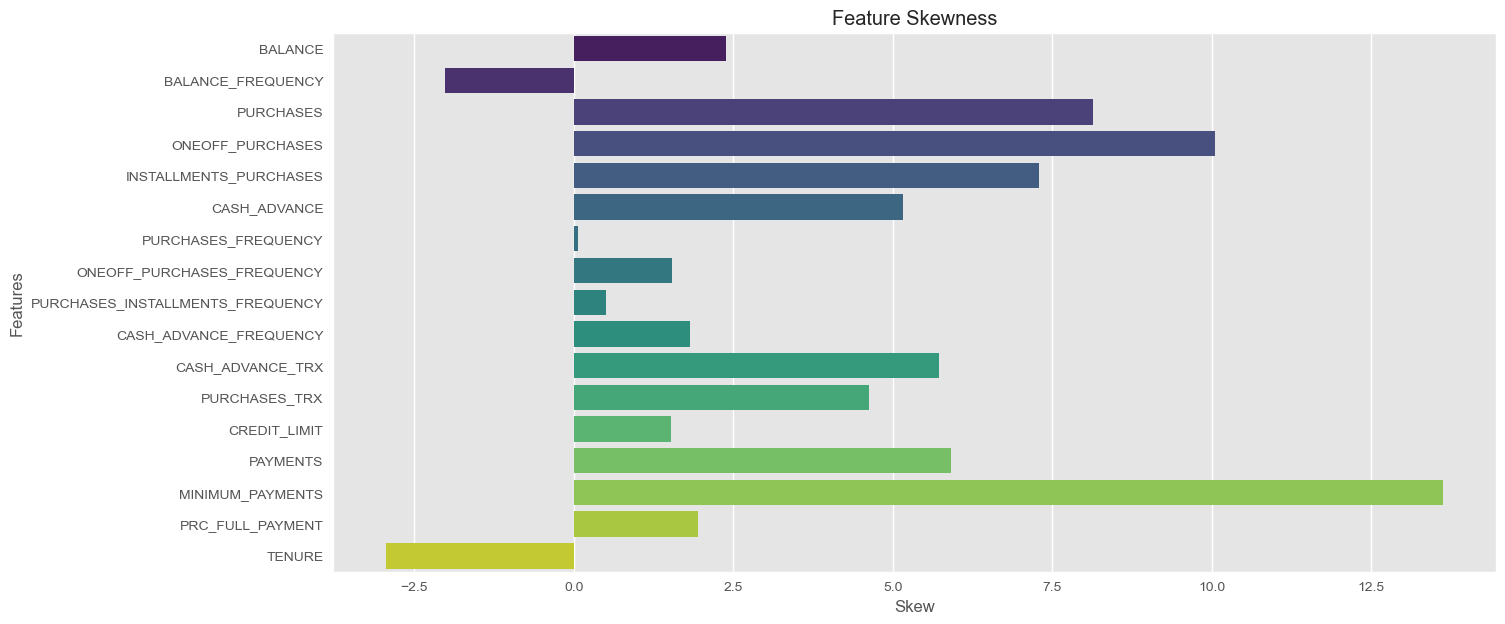

In [9]:
data_skewness = amazon.skew()

plt.figure(figsize=(15, 7))
sns.barplot(x=data_skewness.values, y=data_skewness.index, palette="viridis")
plt.xlabel("Skew")
plt.ylabel("Features")
plt.title("Feature Skewness")
plt.show()

## Handling Missing values

### Using Knn-imputer

In [10]:
knn_imputer = KNNImputer()

knn_impute = pd.DataFrame(knn_imputer.fit_transform(amazon), columns=[i.lower() for i in amazon.columns])

knn_impute.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,379.829982,0.000000,12.0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0


### Preprocess KNN Impute

In [11]:
scaled_knn_impute = pd.DataFrame(StandardScaler().fit_transform(knn_impute), columns=knn_impute.columns)

scaled_knn_impute.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960336,-0.528979,-0.303812,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688696,0.818642,0.093556,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826116,-0.383805,-0.096029,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826116,-0.598688,-0.201440,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905368,-0.364368,-0.258964,-0.525551,0.36068


### Clustering KNN-IMPUTE data

#### Elbow Method
* KMean
* BisectingKMeans
* MiniBatchKMeans

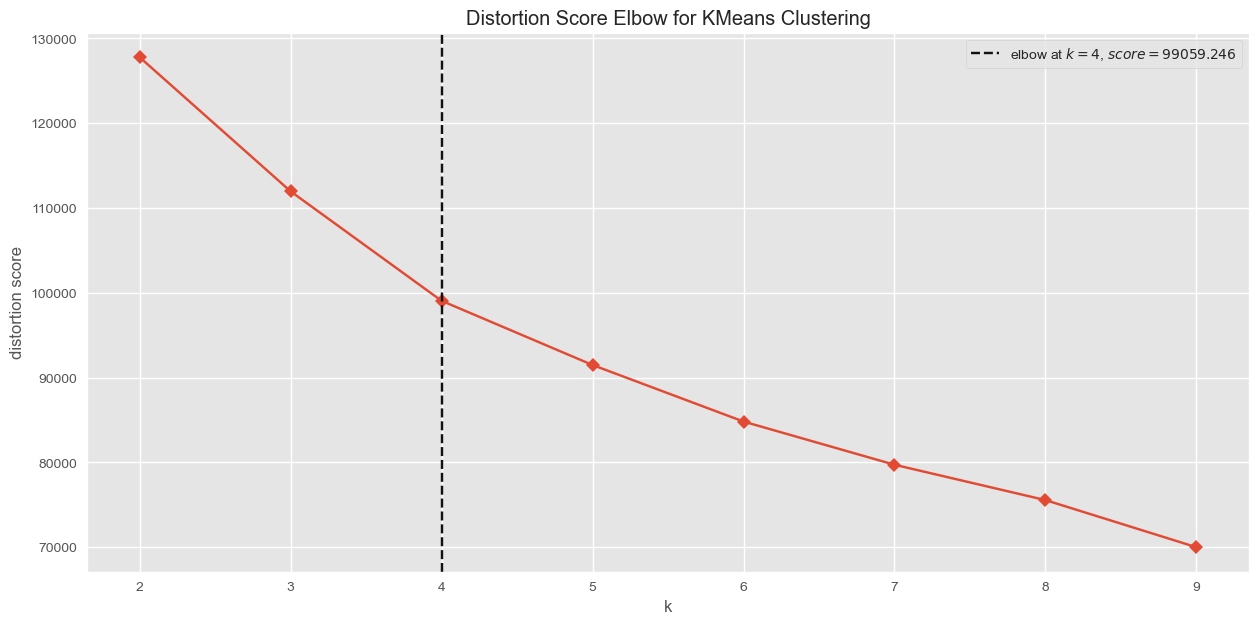

In [12]:
fig, ax = plt.subplots(figsize=(15, 7))

kelbow_visualizer = KElbowVisualizer(estimator=KMeans(), k=(2, 10), ax=ax, timings=False)

kelbow_visualizer.fit(scaled_knn_impute)

kelbow_visualizer.show()

plt.show()

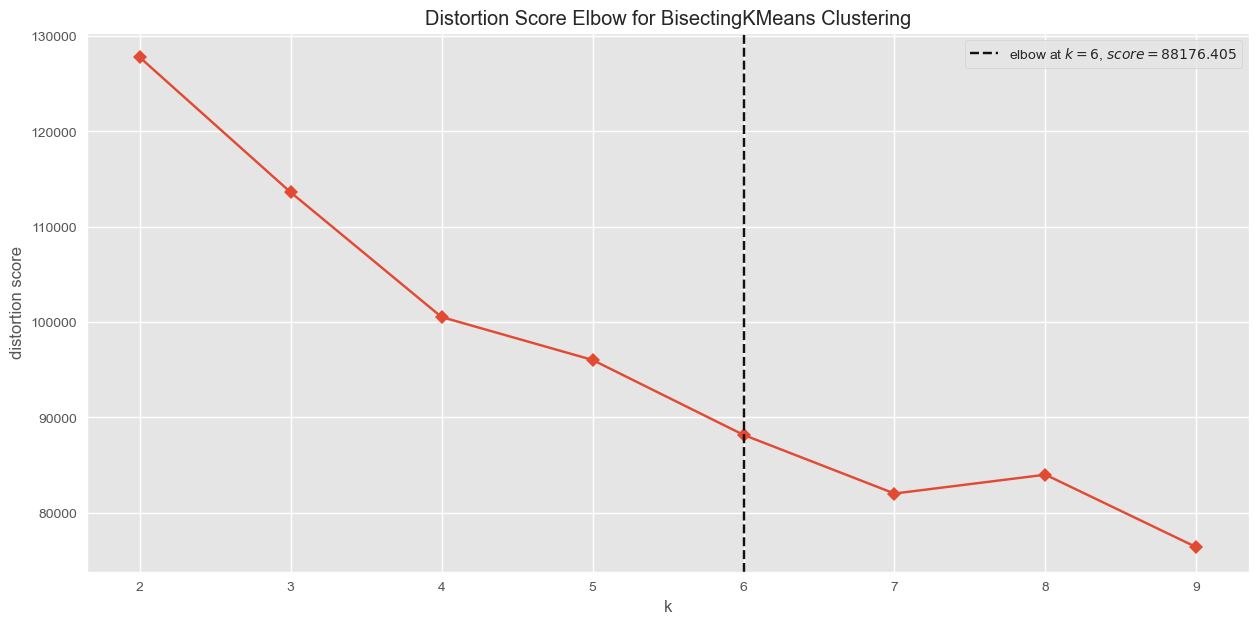

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))

kelbow_visualizer = KElbowVisualizer(estimator=BisectingKMeans(), k=(2, 10), ax=ax, timings=False)

kelbow_visualizer.fit(scaled_knn_impute)

kelbow_visualizer.show()

plt.show()

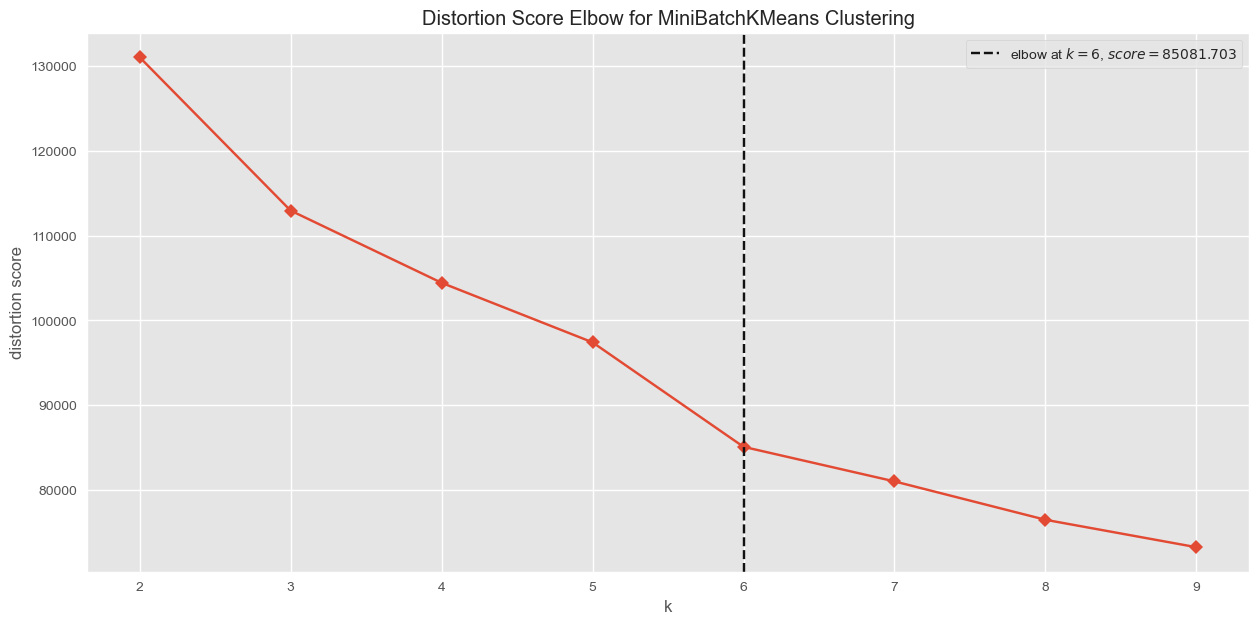

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))

kelbow_visualizer = KElbowVisualizer(estimator=MiniBatchKMeans(), k=(2, 10), ax=ax, timings=False)

kelbow_visualizer.fit(scaled_knn_impute)

kelbow_visualizer.show()

plt.show()

### Silhouette Score

* KMean
* BisectingKMeans
* MiniBatchKMeans

In [43]:
def PLOT_SILHOUETTE_SCORE(X, estimator):
    estimator_name = estimator.__name__
    s_c = []
    
    for i in range(2, 11):
        model = estimator(n_clusters=i)
        model.fit(X)
        pred = model.predict(X)
        s_c.append(silhouette_score(X, pred))

    max_silhouette_index = s_c.index(max(s_c)) + 2

    plt.figure(figsize=(15, 7))
    plt.plot(range(2, 11), s_c, marker="o")
    plt.title(f"Silhouette Score for {estimator_name}")
    plt.axvline(x=max_silhouette_index, ls="--", c="black", label=f"k = {max_silhouette_index} silhouette = {max(s_c)}")
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.show()

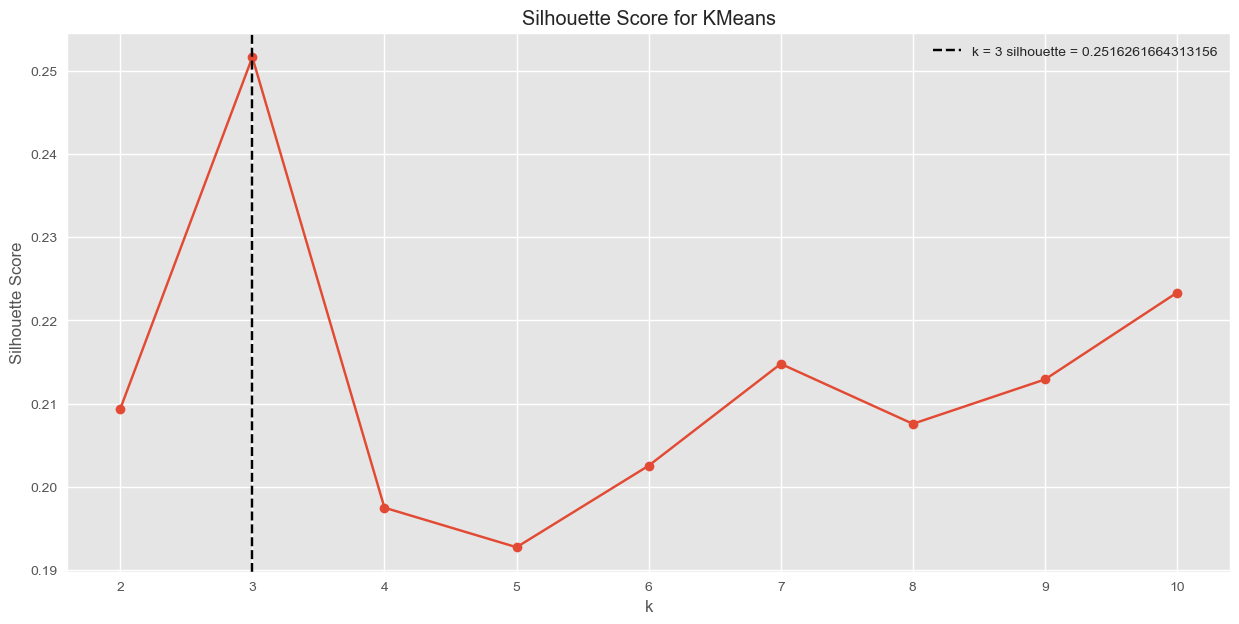

In [44]:
PLOT_SILHOUETTE_SCORE(scaled_knn_impute, KMeans)

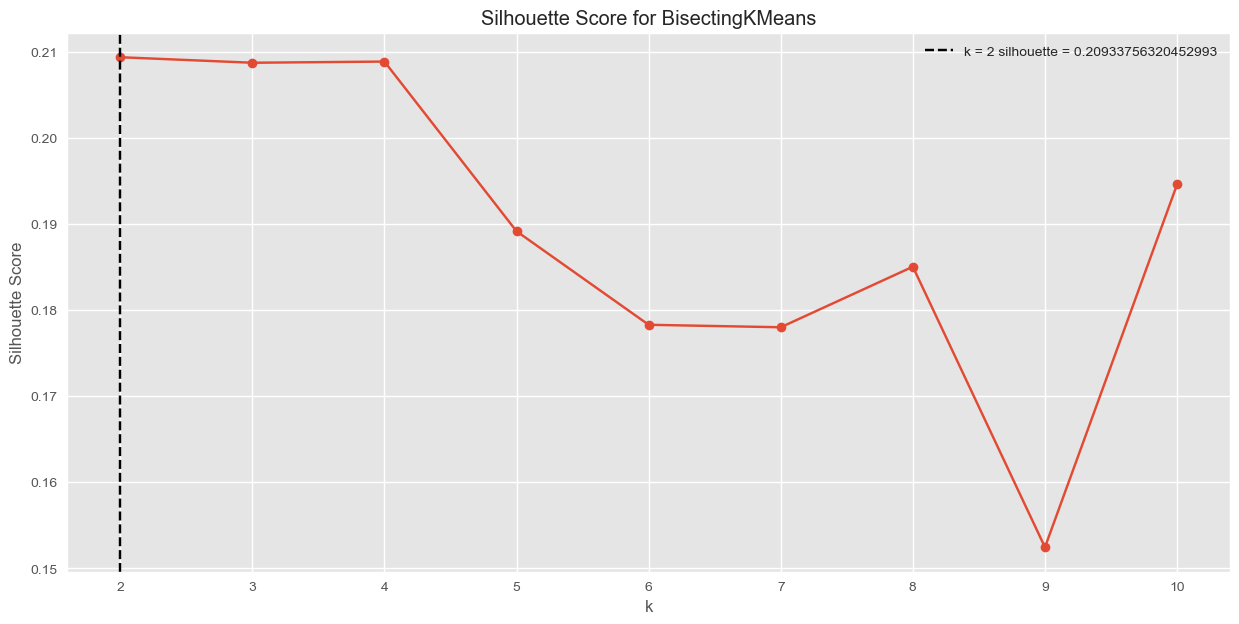

In [45]:
PLOT_SILHOUETTE_SCORE(scaled_knn_impute, BisectingKMeans)

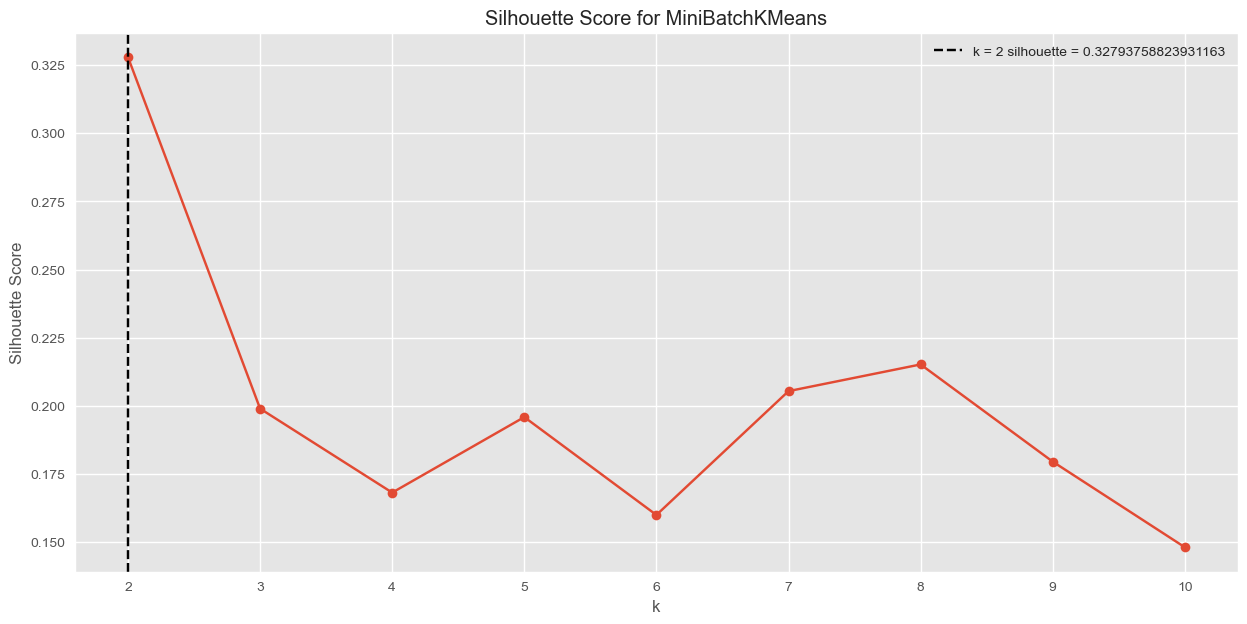

In [46]:
PLOT_SILHOUETTE_SCORE(scaled_knn_impute, MiniBatchKMeans)

### Using Iterative-imputer

In [19]:
iter_imputer = IterativeImputer(estimator=XGBRegressor(), max_iter=20)

iter_impute = pd.DataFrame(iter_imputer.fit_transform(amazon), columns=[i.lower() for i in amazon.columns])\

iter_impute.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,5749.480469,0.000000,12.0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0


### Preprocess Iterative-impute data

In [20]:
scaled_iter_impute = pd.DataFrame(StandardScaler().fit_transform(iter_impute), columns=iter_impute.columns)

scaled_iter_impute.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960271,-0.528979,-0.294538,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688712,0.818642,0.051188,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826127,-0.383805,-0.113759,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826127,-0.598688,1.784629,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905305,-0.364368,-0.255519,-0.525551,0.36068


### Clustering Iterative-impute data

#### Elbow Method
* KMean
* BisectingKMeans
* MiniBatchKMeans

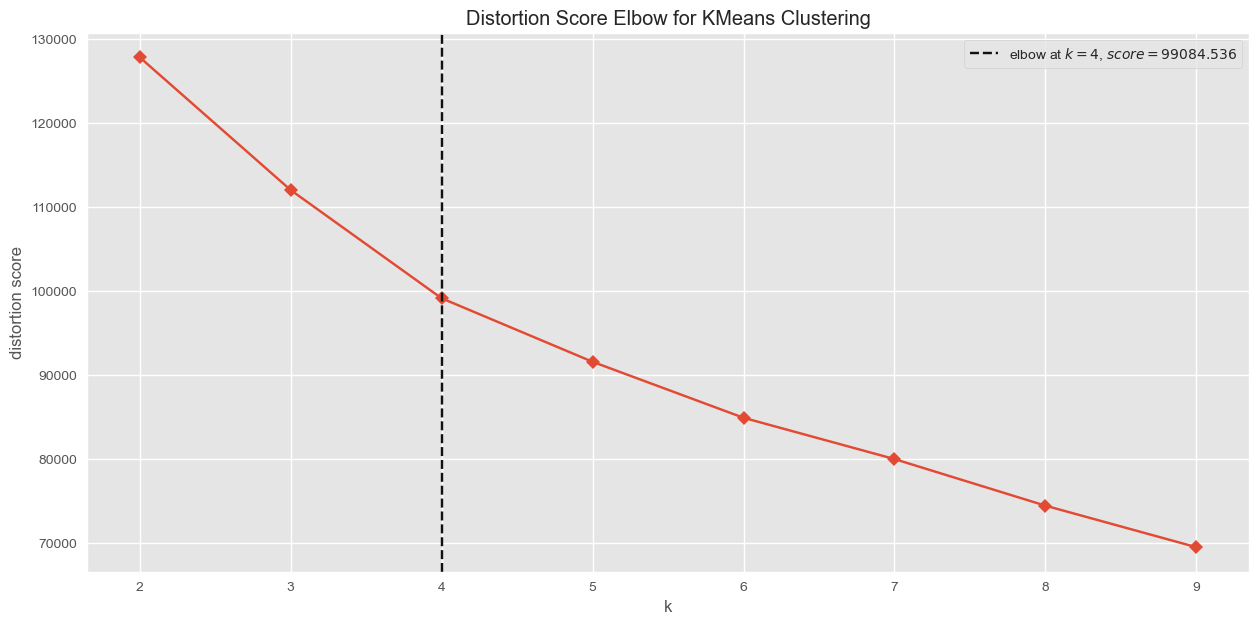

In [21]:
fig, ax = plt.subplots(figsize=(15, 7))

kelbow_visualizer_iter = KElbowVisualizer(estimator=KMeans(), k=(2, 10), ax=ax, timings=False)

kelbow_visualizer_iter.fit(scaled_iter_impute)

kelbow_visualizer_iter.show()

plt.show()

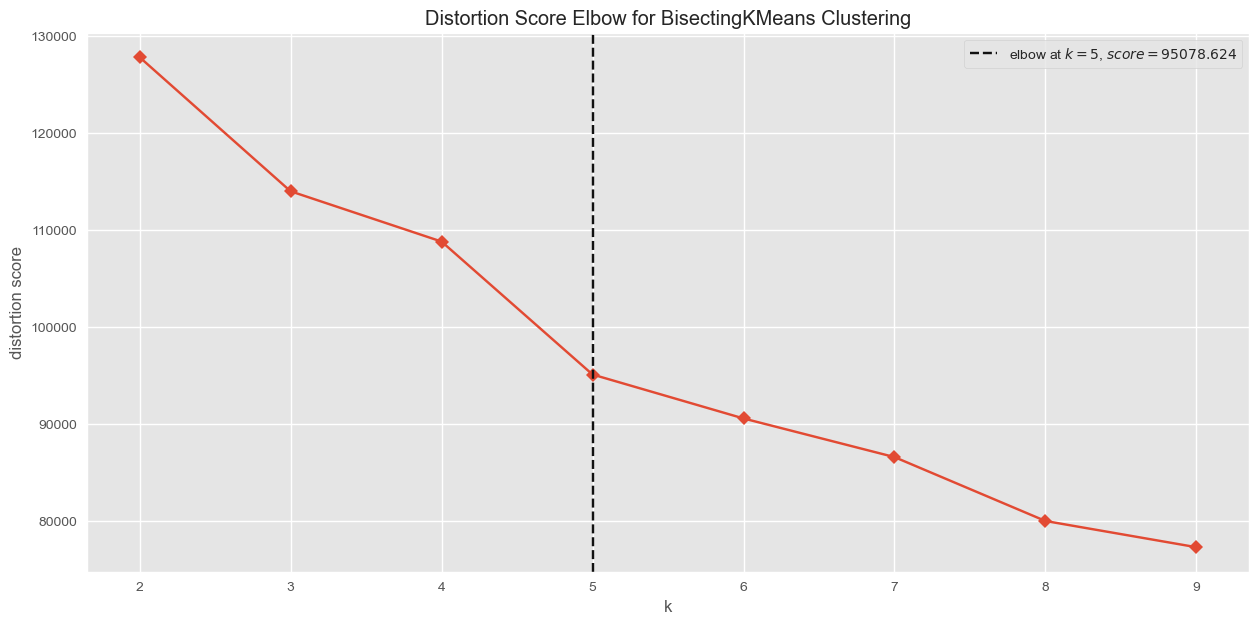

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))

kelbow_visualizer_iter = KElbowVisualizer(estimator=BisectingKMeans(), k=(2, 10), ax=ax, timings=False)

kelbow_visualizer_iter.fit(scaled_iter_impute)

kelbow_visualizer_iter.show()

plt.show()

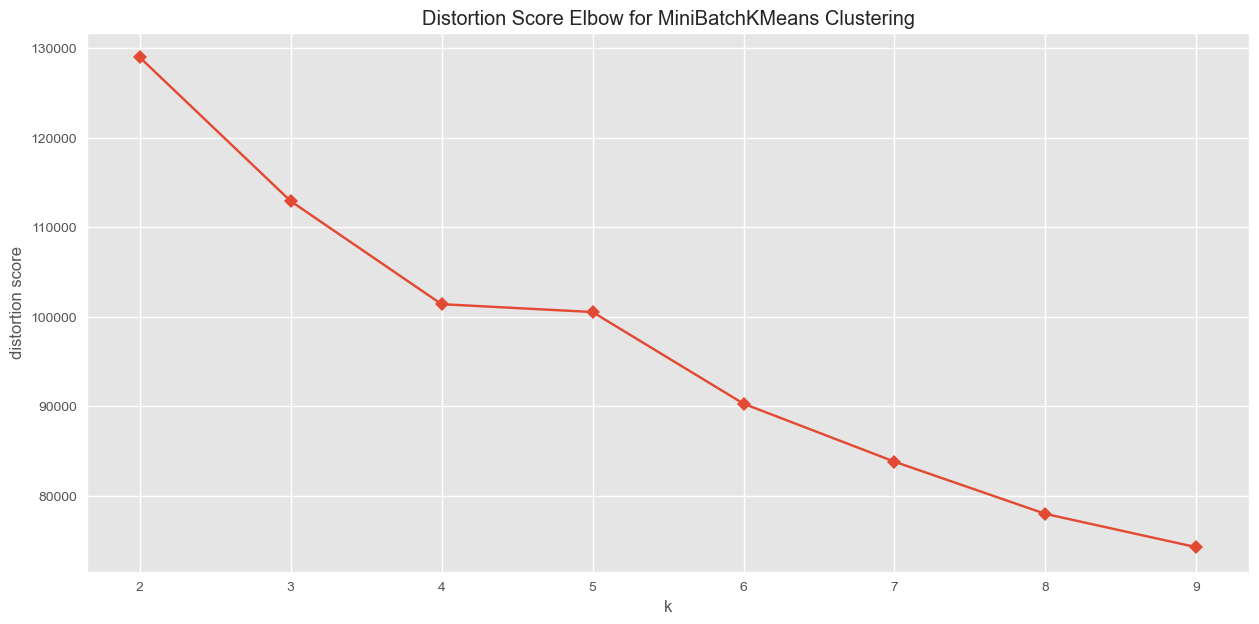

In [23]:
fig, ax = plt.subplots(figsize=(15, 7))

kelbow_visualizer_iter = KElbowVisualizer(estimator=MiniBatchKMeans(), k=(2, 10), ax=ax, timings=False)

kelbow_visualizer_iter.fit(scaled_iter_impute)

kelbow_visualizer_iter.show()

plt.show()

### Silhouette Score

* KMean
* BisectingKMeans
* MiniBatchKMeans

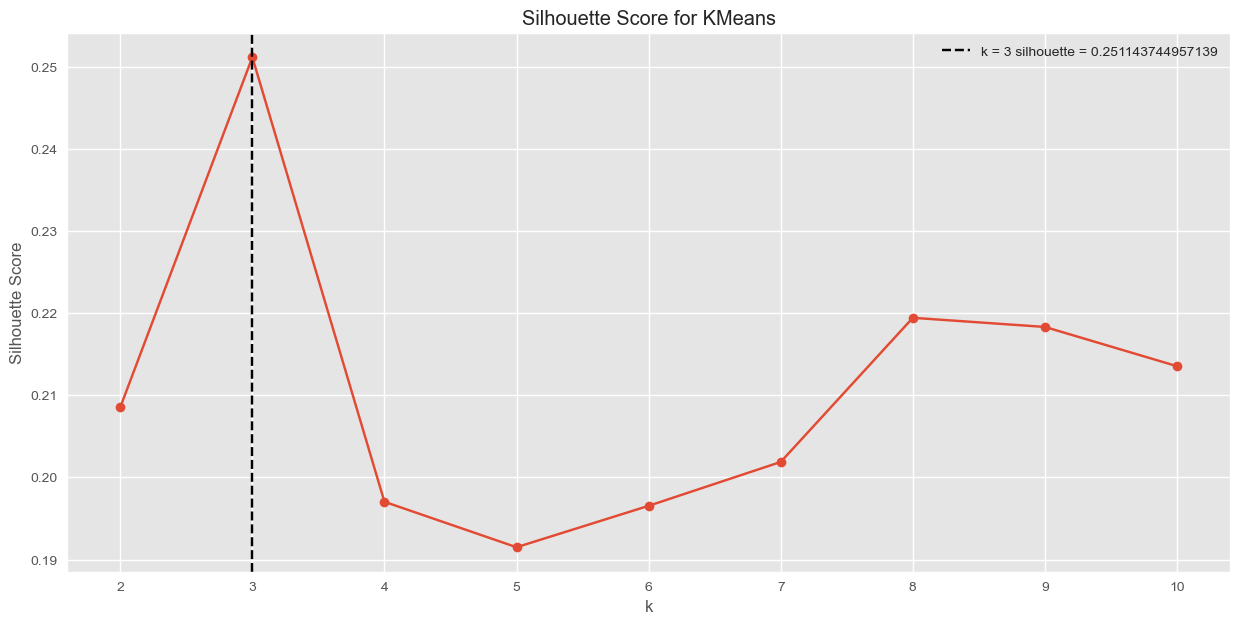

In [47]:
PLOT_SILHOUETTE_SCORE(scaled_iter_impute, KMeans)

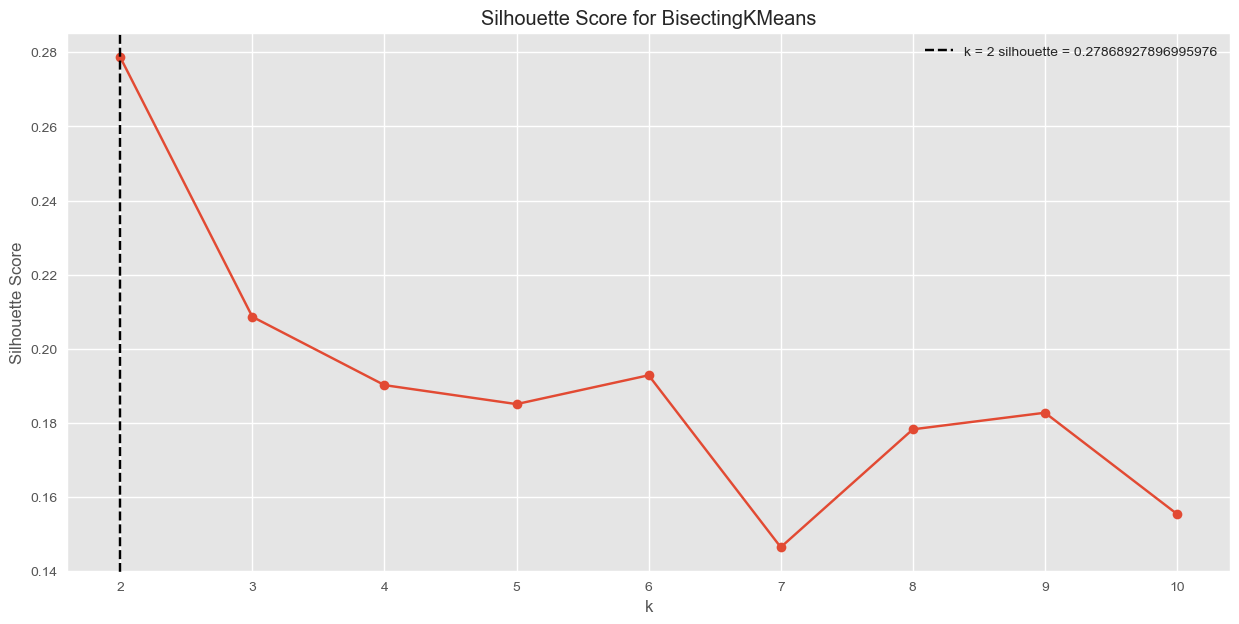

In [48]:
PLOT_SILHOUETTE_SCORE(scaled_iter_impute, BisectingKMeans)

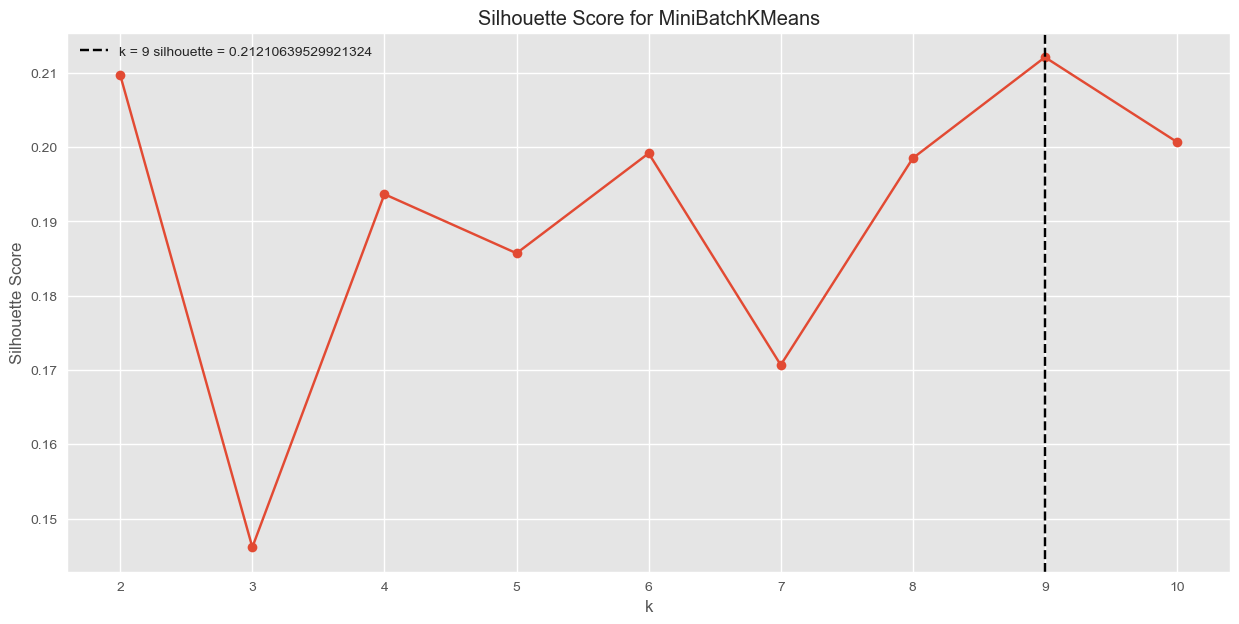

In [49]:
PLOT_SILHOUETTE_SCORE(scaled_iter_impute, MiniBatchKMeans)

## CREATE A PIPELINE

In [53]:
n_clusters = 5

pipe_knn = Pipeline([
                ("IMPUTER", KNNImputer()), # This deals with missing values
                ("SCALER", StandardScaler()), # StandardScaler
                ("KMEAN", KMeans(n_clusters=n_clusters)) # KMeans
])

In [54]:
pipe_knn.fit(amazon)

Pipeline(steps=[('IMPUTER', KNNImputer()), ('SCALER', StandardScaler()),
                ('KMEAN', KMeans(n_clusters=5))])

In [55]:
pipe_knn.predict(amazon)

array([1, 0, 4, ..., 2, 1, 1])

In [56]:
pipe_iter = Pipeline([
                ("IMPUTER", IterativeImputer(estimator=XGBRegressor())), # This deals with missing values
                ("SCALER", StandardScaler()), # StandardScaler
                ("KMEAN", KMeans(n_clusters=n_clusters)) # KMeans
])

In [57]:
pipe_iter.fit(amazon)

Pipeline(steps=[('IMPUTER',
                 IterativeImputer(estimator=XGBRegressor(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importance_type=None,
                                                         interaction_constraints=None,
                                                         learning_rate=None,
                                                         max_bin=None,
                                                         max_cat_threshold=None,
                                                         max_cat_to_onehot=None,
                                                         max_delta_step=None,
                                                         max_depth=None,
                                                         max_leaves=None,
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         multi_strategy=None,
                                                         n_estimators=None,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         random_state=None, ...))),
                ('SCALER', StandardScaler()), ('KMEAN', KMeans(n_clusters=5))])

In [58]:
pipe_iter.predict(amazon)

array([1, 4, 3, ..., 0, 1, 1])

## Decision Boundary

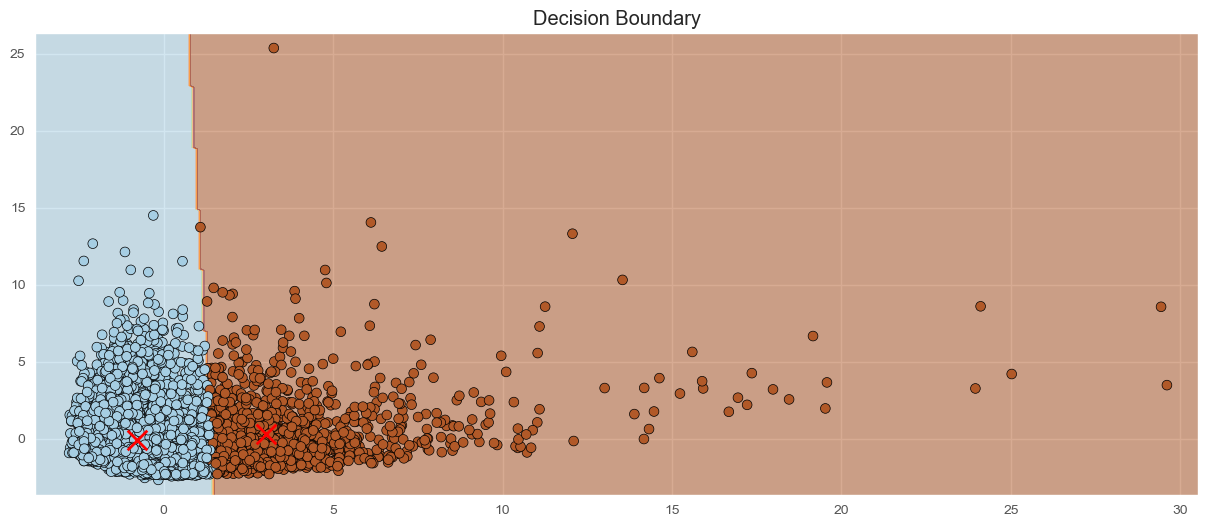

In [140]:
reduced_knn = PCA(n_components=2).fit_transform(scaled_knn_impute)

minibatchkmean = MiniBatchKMeans(n_clusters=2)

minibatchkmean.fit(reduced_knn)

x_min, x_max = reduced_knn[:, 0].min() - 1, reduced_knn[:, 0].max() + 1
y_min, y_max = reduced_knn[:, 1].min() - 1, reduced_knn[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = kmean.predict(np.c_[xx.flatten(), yy.flatten()])

z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 6))
plt.contourf(xx, yy, z, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(reduced_knn[:, 0], reduced_knn[:, 1], c=kmean.labels_, cmap=plt.cm.Paired, edgecolors="black")
plt.scatter(minibatchkmean.cluster_centers_[:, 0], minibatchkmean.cluster_centers_[:, 1], marker="x", s=200, lw=2, color="red")
plt.title("Decision Boundary")
plt.show()

## Pipeline

In [142]:
def Cluster_data(estimator, X, n_clusters):
    algo = estimator(n_clusters=n_clusters)
    PIPELINE = Pipeline([
        ("IMPUTER", KNNImputer()),
        ("SCALER", StandardScaler()),
        ("CLUSTER_ALGORITHM", algo)
    ])

    PIPELINE.fit(X)

    return PIPELINE.predict(X)

In [145]:
test_df = amazon.copy()

In [146]:
test_df["kmean_clusters"] = Cluster_data(KMeans, amazon, 3)
test_df["bisecting_kmean_clusters"] = Cluster_data(BisectingKMeans, amazon, 2)
test_df["minibatchkmean_clusters"] = Cluster_data(MiniBatchKMeans, amazon, 2)

In [151]:
test_df[test_df["kmean_clusters"] == 0].head().style.background_gradient(cmap="viridis")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmean_clusters,bisecting_kmean_clusters,minibatchkmean_clusters
0,40.900749,0.818182,95.400000,0.000000,95.400000,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.000000,201.802084,139.509787,0.000000,12,0,0,1
2,2495.148862,1.000000,773.170000,773.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.000000,622.066742,627.284787,0.000000,12,0,1,0
3,1666.670542,0.636364,1499.000000,1499.000000,0.000000,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.000000,0.000000,nan,0.000000,12,0,0,1
4,817.714335,1.000000,16.000000,16.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.000000,678.334763,244.791237,0.000000,12,0,0,1
5,1809.828751,1.000000,1333.280000,0.000000,1333.280000,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.000000,1400.057770,2407.246035,0.000000,12,0,0,0


In [152]:
test_df[test_df["kmean_clusters"] == 1].head().style.background_gradient(cmap="viridis")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmean_clusters,bisecting_kmean_clusters,minibatchkmean_clusters
1,3202.467416,0.909091,0.000000,0.000000,0.000000,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.000000,4103.032597,1072.340217,0.222222,12,1,0,1
15,6886.213231,1.000000,1611.700000,0.000000,1611.700000,2301.491267,0.500000,0.000000,0.500000,0.166667,4,11,8000.000000,1993.439277,2109.906490,0.000000,12,1,0,1
23,3800.151377,0.818182,4248.350000,3454.560000,793.790000,7974.415626,1.000000,0.083333,0.916667,0.333333,13,13,9000.000000,9479.043842,1425.426525,0.000000,12,1,1,0
24,5368.571219,1.000000,0.000000,0.000000,0.000000,798.949863,0.000000,0.000000,0.000000,0.363636,4,0,6000.000000,1422.726707,1657.002877,0.000000,11,1,0,1
28,7152.864372,1.000000,387.050000,204.550000,182.500000,2236.145259,0.666667,0.166667,0.416667,0.833333,16,8,10500.000000,1601.448347,1648.851345,0.000000,12,1,0,1


In [153]:
test_df[test_df["kmean_clusters"] == 2].head().style.background_gradient(cmap="viridis")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmean_clusters,bisecting_kmean_clusters,minibatchkmean_clusters
6,627.260806,1.000000,7091.010000,6402.630000,688.380000,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.000000,6354.314328,198.065894,1.000000,12,2,1,0
12,1516.928620,1.000000,3217.990000,2500.230000,717.760000,0.000000,1.000000,0.250000,0.916667,0.000000,0,26,3000.000000,608.263689,490.207013,0.250000,12,2,1,0
21,6369.531318,1.000000,6359.950000,5910.040000,449.910000,229.028245,1.000000,0.916667,1.000000,0.333333,6,92,11250.000000,2077.959051,1659.775075,0.000000,12,2,1,0
34,3517.101616,0.727273,547.280000,0.000000,547.280000,0.000000,1.000000,0.000000,1.000000,0.000000,0,14,11000.000000,8735.607835,17862.558310,0.000000,12,2,1,0
37,4047.480828,1.000000,2380.550000,1642.170000,738.380000,1697.660901,0.750000,0.500000,0.750000,0.333333,7,41,5000.000000,1617.894416,1541.141605,0.000000,12,2,1,0


In [154]:
test_df[test_df["bisecting_kmean_clusters"] == 0].head().style.background_gradient(cmap="viridis")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmean_clusters,bisecting_kmean_clusters,minibatchkmean_clusters
0,40.900749,0.818182,95.400000,0.000000,95.400000,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.000000,201.802084,139.509787,0.000000,12,0,0,1
1,3202.467416,0.909091,0.000000,0.000000,0.000000,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.000000,4103.032597,1072.340217,0.222222,12,1,0,1
3,1666.670542,0.636364,1499.000000,1499.000000,0.000000,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.000000,0.000000,nan,0.000000,12,0,0,1
4,817.714335,1.000000,16.000000,16.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.000000,678.334763,244.791237,0.000000,12,0,0,1
5,1809.828751,1.000000,1333.280000,0.000000,1333.280000,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.000000,1400.057770,2407.246035,0.000000,12,0,0,0


In [155]:
test_df[test_df["bisecting_kmean_clusters"] == 1].head().style.background_gradient(cmap="viridis")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmean_clusters,bisecting_kmean_clusters,minibatchkmean_clusters
2,2495.148862,1.000000,773.170000,773.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.000000,622.066742,627.284787,0.000000,12,0,1,0
6,627.260806,1.000000,7091.010000,6402.630000,688.380000,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.000000,6354.314328,198.065894,1.000000,12,2,1,0
12,1516.928620,1.000000,3217.990000,2500.230000,717.760000,0.000000,1.000000,0.250000,0.916667,0.000000,0,26,3000.000000,608.263689,490.207013,0.250000,12,2,1,0
13,921.693369,1.000000,2137.930000,419.960000,1717.970000,0.000000,0.750000,0.166667,0.750000,0.000000,0,26,7500.000000,1655.891435,251.137986,0.083333,12,0,1,0
21,6369.531318,1.000000,6359.950000,5910.040000,449.910000,229.028245,1.000000,0.916667,1.000000,0.333333,6,92,11250.000000,2077.959051,1659.775075,0.000000,12,2,1,0


In [156]:
test_df[test_df["minibatchkmean_clusters"] == 0].head().style.background_gradient(cmap="viridis")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmean_clusters,bisecting_kmean_clusters,minibatchkmean_clusters
2,2495.148862,1.000000,773.170000,773.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.000000,622.066742,627.284787,0.000000,12,0,1,0
5,1809.828751,1.000000,1333.280000,0.000000,1333.280000,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.000000,1400.057770,2407.246035,0.000000,12,0,0,0
6,627.260806,1.000000,7091.010000,6402.630000,688.380000,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.000000,6354.314328,198.065894,1.000000,12,2,1,0
7,1823.652743,1.000000,436.200000,0.000000,436.200000,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.000000,679.065082,532.033990,0.000000,12,0,0,0
10,1293.124939,1.000000,920.120000,0.000000,920.120000,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,1200.000000,1083.301007,2172.697765,0.000000,12,0,0,0


In [157]:
test_df[test_df["minibatchkmean_clusters"] == 1].head().style.background_gradient(cmap="viridis")

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmean_clusters,bisecting_kmean_clusters,minibatchkmean_clusters
0,40.900749,0.818182,95.400000,0.000000,95.400000,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.000000,201.802084,139.509787,0.000000,12,0,0,1
1,3202.467416,0.909091,0.000000,0.000000,0.000000,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.000000,4103.032597,1072.340217,0.222222,12,1,0,1
3,1666.670542,0.636364,1499.000000,1499.000000,0.000000,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.000000,0.000000,nan,0.000000,12,0,0,1
4,817.714335,1.000000,16.000000,16.000000,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.000000,678.334763,244.791237,0.000000,12,0,0,1
8,1014.926473,1.000000,861.490000,661.490000,200.000000,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.000000,688.278568,311.963409,0.000000,12,0,0,1


## Decision Boundary

In [165]:
def Plot_Decision_Boundary(estimator, X, n_clusters):
    algo = estimator(n_clusters=n_clusters)
    reduced_X = PCA(n_components=2).fit_transform(X)
    algo.fit(reduced_X)
    x_min, x_max = reduced_X[:, 0].min() - 1, reduced_X[:, 1].max() + 1
    y_min, y_max = reduced_X[:, 1].min() - 1, reduced_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = algo.predict(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(15, 7))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)
    plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=algo.labels_, cmap=plt.cm.Paired, edgecolor="k")
    plt.scatter(algo.cluster_centers_[:, 0], algo.cluster_centers_[:, 1],
                cmap=plt.cm.Paired, marker="x", s=200, lw=2, color="k")
    plt.title(f"Decision Boundary for {estimator.__name__} (PCA Reduced)")
    plt.show()

Number of clusters: 2


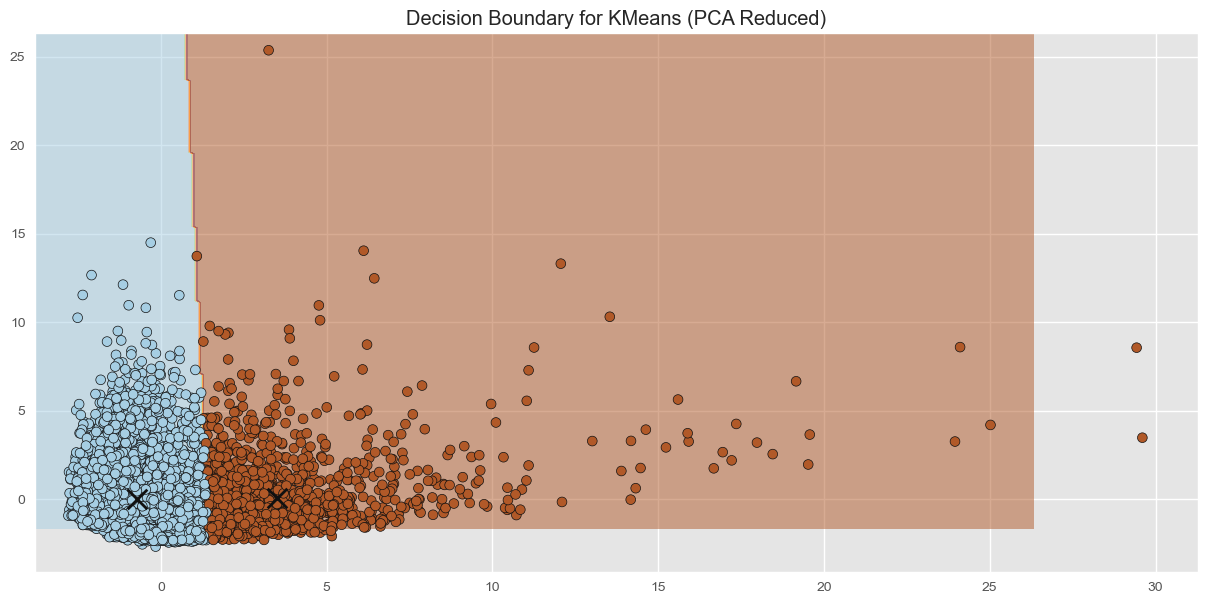

Number of clusters: 3


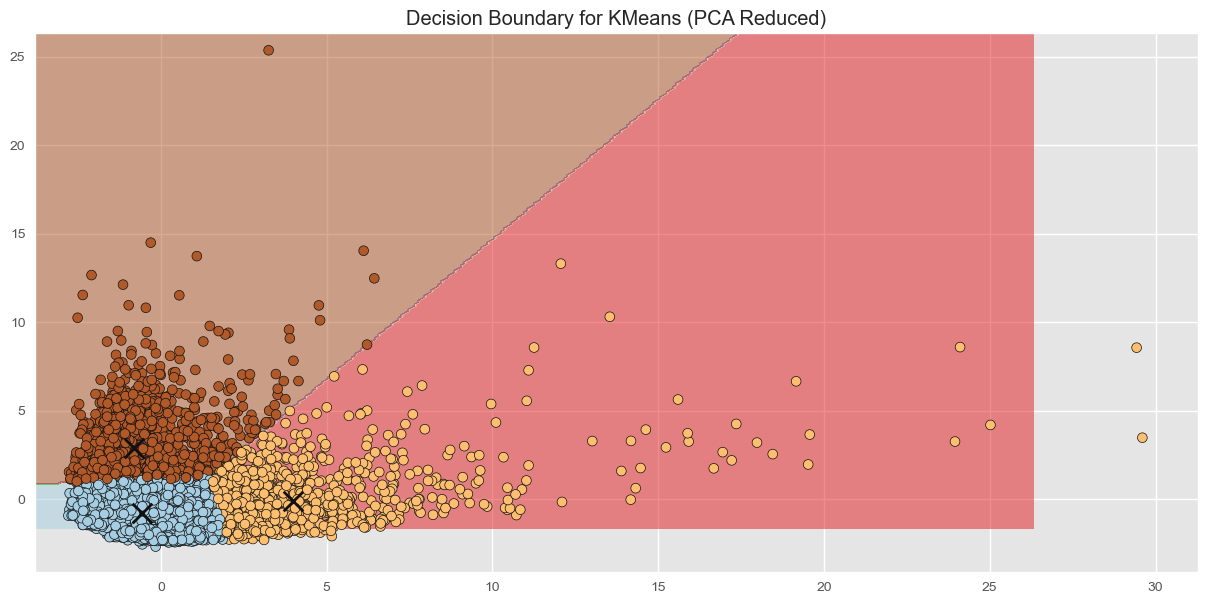

Number of clusters: 4


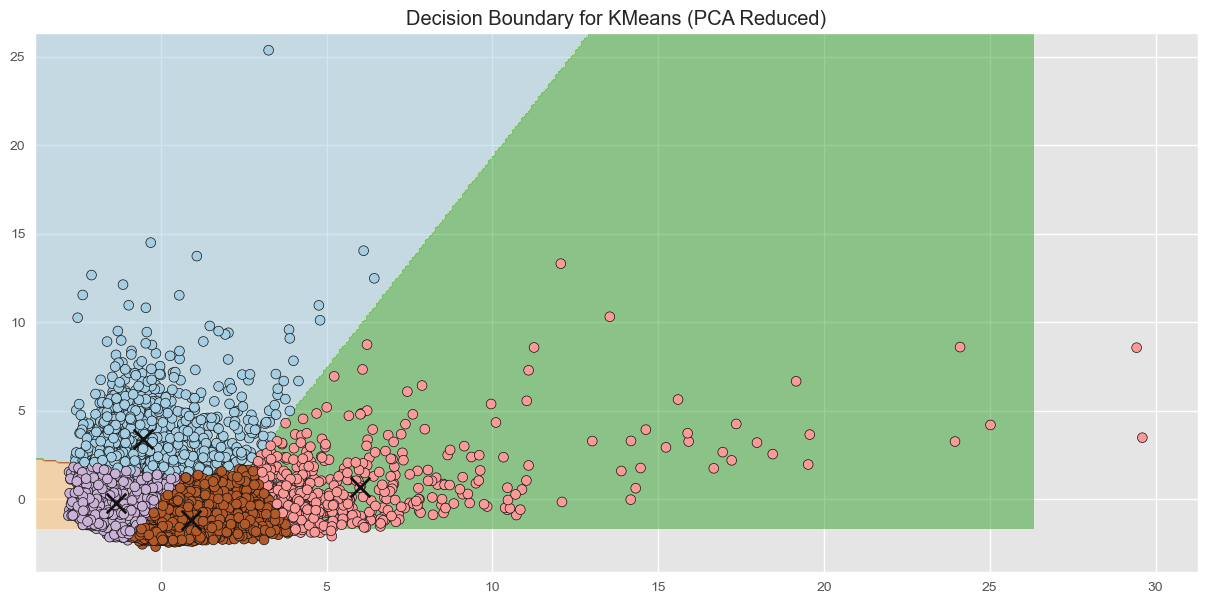

Number of clusters: 5


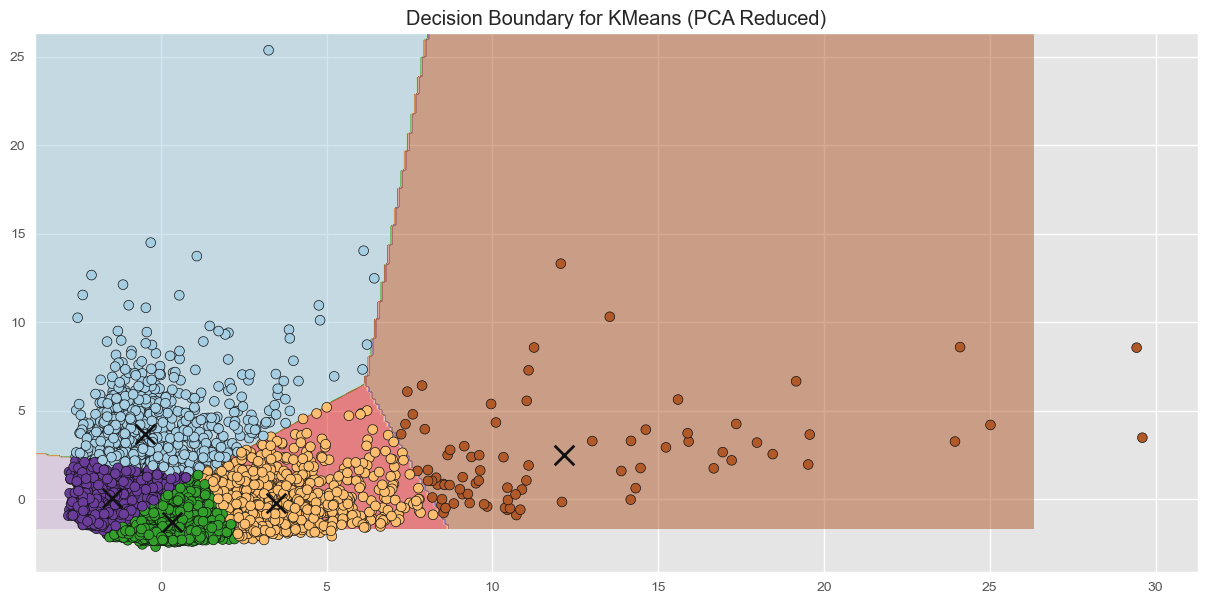

In [171]:
for i in range(2, 6):
    print(f"Number of clusters: {i}")
    Plot_Decision_Boundary(KMeans, scaled_knn_impute, i)

## Eddy